In [4]:
# This script provides a minimal, educational implementation of the Diffusion Transformer (DiT)
# model, as introduced in the paper "Scalable Diffusion Models with Transformers" by
# William Peebles and Saining Xie (https://arxiv.org/abs/2212.09748).
#
# This implementation is intended for educational purposes to demystify the DiT architecture.
# It is not an official implementation from the paper's authors.

import torch
import torch.nn as nn
from torch.nn import functional as F
import math
from dataclasses import dataclass

@dataclass
class DiTConfig:
    image_size: int = 256
    patch_size: int = 16
    in_channels: int = 3
    n_embd: int = 768
    n_head: int = 12
    n_layer: int = 12
    dropout: float = 0.1

    @property
    def n_ctx(self):
        return (self.image_size // self.patch_size) ** 2

class SelfAttention(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p, is_causal=False)
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class DiTBlock(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.norm1 = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.attn = SelfAttention(config)
        self.norm2 = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.mlp = FeedForward(config)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(config.n_embd, 6 * config.n_embd, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

class FinalLayer(nn.Module):
    def __init__(self, config: DiTConfig):
        super().__init__()
        self.norm_final = nn.LayerNorm(config.n_embd, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(config.n_embd, config.patch_size * config.patch_size * config.in_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(config.n_embd, 2 * config.n_embd, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

class TimestepEmbedder(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        return self.mlp(t_freq)

class DiT(nn.Module):
    def __init__(self, config: DiTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.in_channels = config.in_channels
        self.out_channels = config.in_channels
        self.patch_size = config.patch_size
        self.num_heads = config.n_head

        self.x_embedder = nn.Conv2d(self.in_channels, config.n_embd, kernel_size=self.patch_size, stride=self.patch_size)
        self.t_embedder = TimestepEmbedder(config.n_embd)
        self.y_embedder = nn.Embedding(num_classes, config.n_embd)

        self.pos_embed = nn.Parameter(torch.zeros(1, config.n_ctx, config.n_embd))

        self.blocks = nn.ModuleList([
            DiTBlock(config) for _ in range(config.n_layer)
        ])
        self.final_layer = FinalLayer(config)
        self.initialize_weights()

    def initialize_weights(self):
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        nn.init.normal_(self.pos_embed, std=0.02)

        nn.init.normal_(self.y_embedder.weight, std=0.02)

        nn.init.kaiming_normal_(self.x_embedder.weight, mode="fan_in", nonlinearity="relu")

        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)

    def unpatchify(self, x):
        c = self.out_channels
        p = self.patch_size
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, w * p))
        return imgs

    def forward(self, x, t, y):
        x = self.x_embedder(x).flatten(2).transpose(1, 2)
        x = x + self.pos_embed

        t = self.t_embedder(t)
        y = self.y_embedder(y)
        c = t + y

        for block in self.blocks:
            x = block(x, c)

        x = self.final_layer(x, c)
        x = self.unpatchify(x)
        return x

Loading dataset from Hugging Face...
Loading dataset 'conceptual_captions' in streaming mode...
Filtering for 500 valid image samples...


Filtering samples: 717it [03:01,  3.95it/s]                         


Successfully loaded and filtered 500 images.
Dataset split: 450 training samples, 50 validation samples.
Initializing DiT model on cuda...
Compiling model with torch.compile()...
Starting training...


Epoch 1/20:   0%|          | 0/1 [00:00<?, ?it/s]W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT forward /tmp/ipykernel_138/3147336823.py line 181 
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233] due to: 
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233]              ^^^^^^^^^^^^^^^^^^^^
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.11/dist-packages/torch/_dynamo/convert_frame.py", line 547, in __call__
W0713 22:34:27.273000 138 torch/_dynamo/convert_frame.py:1233]     return _compile(
W0713 22:34:27.273000 138 torch/_dynamo/co

Epoch 1 Validation Loss: 1.7365
Epoch 1: Generating sample image...


FileNotFoundError: [Errno 2] No such file or directory: 'images/0.png'

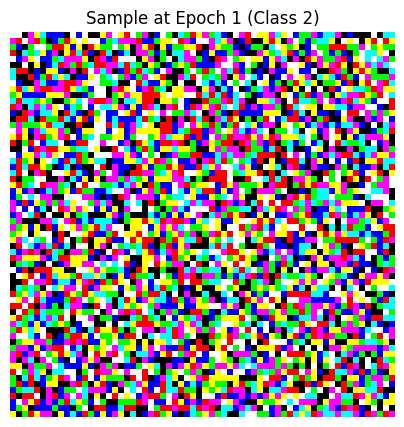

In [ ]:


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import os
import math
import json
from tqdm import tqdm
import random
# Added imports
import requests
from io import BytesIO
from itertools import islice
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional


import torch._dynamo
torch._dynamo.config.suppress_errors = True

bruh = 0
# Assuming model.py contains the DiT and DiTConfig classes
# from model import DiT, DiTConfig

# --- 1. DATA HANDLING (Replaced DummyImageDataset) ---

def download_image(url: str) -> Optional[Image.Image]:
    """Download image from URL and return PIL Image object."""
    try:
        response = requests.get(url, timeout=10, headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        })
        if response.status_code == 200:
            # Ensure image is RGB
            return Image.open(BytesIO(response.content)).convert('RGB')
    except Exception:
        # Silently fail on download error to avoid spamming the console
        pass
    return None

class CustomImageDataset(Dataset):
    """
    A dataset that loads and filters images from a Hugging Face dataset.
    It uses real images but generates random class labels to match the model's expected input.
    """
    def __init__(self, dataset_name="conceptual_captions", num_samples=1000, image_size=256, num_classes=10):
        self.image_size = image_size
        self.num_classes = num_classes
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize to [-1, 1]
        ])
        
        self.data = self._load_and_filter_data(dataset_name, num_samples)
        if not self.data:
            raise RuntimeError(f"Could not load any valid data from '{dataset_name}'. Please check the dataset or your connection.")

    def _load_and_filter_data(self, dataset_name, num_samples_to_find):
        print(f"Loading dataset '{dataset_name}' in streaming mode...")
        try:
            dataset_stream = load_dataset(dataset_name, split="train", streaming=True, trust_remote_code=True)
        except Exception as e:
            print(f"Failed to load dataset '{dataset_name}': {e}")
            return []

        print(f"Filtering for {num_samples_to_find} valid image samples...")
        filtered_images = []
        
        # Iterate through more samples than needed to account for filtering
        # Stop after checking a reasonable multiple of the target, e.g., 10x
        max_to_check = num_samples_to_find * 10
        
        pbar = tqdm(islice(dataset_stream, max_to_check), total=num_samples_to_find, desc="Filtering samples")

        for sample in pbar:
            if len(filtered_images) >= num_samples_to_find:
                break

            url = sample.get('image_url') or sample.get('url') # Support different key names
            caption = sample.get('caption') or sample.get('text')

            if url and isinstance(url, str) and caption and isinstance(caption, str):
                img = download_image(url)
                if img:
                    filtered_images.append(img)
                    pbar.update(1)
        
        pbar.close()
        if len(filtered_images) < num_samples_to_find:
            print(f"Warning: Could only find {len(filtered_images)} valid images out of the requested {num_samples_to_find}.")
        
        print(f"Successfully loaded and filtered {len(filtered_images)} images.")
        return filtered_images

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        
        # Assign a random class label, as the model is class-conditional
        label = torch.randint(0, self.num_classes, (1,)).item()
        
        return self.transform(img), label

# --- 2. DIFFUSION UTILITIES ---

def get_beta_schedule(num_diffusion_timesteps):
    """
    Returns a linear beta schedule.
    """
    betas = torch.linspace(0.0001, 0.02, num_diffusion_timesteps)
    return betas

def q_sample(x_start, t, alphas_cumprod, noise=None):
    """
    Forward diffusion process: add noise to an image.
    """
    if noise is None:
        noise = torch.randn_like(x_start)
    
    sqrt_alphas_cumprod_t = torch.sqrt(alphas_cumprod[t])[:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = torch.sqrt(1.0 - alphas_cumprod[t])[:, None, None, None]
    
    noisy_image = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    return noisy_image

# --- 3. SAMPLING & VALIDATION ---

@torch.no_grad()
def p_sample_loop(model, shape, num_timesteps, alphas, betas, alphas_cumprod, device, class_label=0):
    """
    Reverse diffusion process: generate an image from noise.
    """
    img = torch.randn(shape, device=device)
    
    # Create a fixed class label tensor for the batch
    labels = torch.tensor([class_label] * shape[0], device=device)

    for i in tqdm(reversed(range(num_timesteps)), desc="Sampling", total=num_timesteps, leave=False):
        t = torch.full((shape[0],), i, device=device, dtype=torch.long)
        
        # The model might be wrapped in DataParallel or torch.compile
        model_to_run = model.module if isinstance(model, (nn.DataParallel, nn.parallel.DistributedDataParallel)) else model
        predicted_noise = model_to_run(img, t, labels)
        
        alpha_t = alphas[t][:, None, None, None]
        alpha_cumprod_t = alphas_cumprod[t][:, None, None, None]
        beta_t = betas[t][:, None, None, None]
        
        # DDPM sampling step
        if i > 0:
            noise = torch.randn_like(img)
        else:
            noise = torch.zeros_like(img)
            
        img = 1 / torch.sqrt(alpha_t) * (img - ((1 - alpha_t) / torch.sqrt(1 - alpha_cumprod_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
        
    return img

def show_sample_image(tensor, title=""):
    """
    Display a tensor as an image using matplotlib.
    Assumes the script is run in a notebook environment where plt.show() is non-blocking.
    """
    # Denormalize from [-1, 1] to [0, 1]
    tensor = (tensor + 1) / 2
    tensor.clamp_(0, 1)
    
    # Convert to numpy array and transpose for matplotlib
    # (C, H, W) -> (H, W, C)
    img_np = tensor.cpu().numpy().transpose(1, 2, 0)
    
    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.title(title)
    plt.axis('off')
    # plt.savefig(f"images/{bruh}")#savefig
    plt.show()

@torch.no_grad()
def validate(model, dataloader, num_diffusion_timesteps, alphas_cumprod, criterion, device):
    """
    Validation loop. Runs entirely on the specified device.
    """
    model.eval()
    total_loss = 0.0
    progress_bar = tqdm(dataloader, desc="Validating", leave=False)
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)
        
        t = torch.randint(0, num_diffusion_timesteps, (images.shape[0],), device=device).long()
        noise = torch.randn_like(images)
        noisy_images = q_sample(images, t, alphas_cumprod, noise)
        
        predicted_noise = model(noisy_images, t, labels)
        loss = criterion(predicted_noise, noise)
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    model.train()
    return total_loss / len(dataloader)

# --- 4. TRAINING SCRIPT ---

def main():
    # --- Config ---
    config = DiTConfig(
        image_size=64,      # Use smaller images for faster training
        patch_size=8,
        in_channels=3,
        n_embd=512,
        n_head=8,
        n_layer=6,
        dropout=0.1
           
    )
    
    # Training Hyperparameters
    epochs = 100 
    batch_size = 32 #32
    learning_rate = 4e-3#1e-4
    num_classes = 10 # Number of classes for the conditional model
    num_diffusion_timesteps = 1000
    validation_split = 0.1 # Use 10% of the data for validation
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # --- Dataset and DataLoader ---
    print("Loading dataset from Hugging Face...")
    dataset = CustomImageDataset(
        num_samples=3000, 
        image_size=config.image_size, 
        num_classes=num_classes
    )
    
    # Split dataset into training and validation
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    
    print(f"Dataset split: {len(train_dataset)} training samples, {len(val_dataset)} validation samples.")
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    # --- Model, Optimizer, Loss ---
    print(f"Initializing DiT model on {device}...")
    model = DiT(config, num_classes=num_classes)
    
    print("Compiling model with torch.compile()...")
    model = torch.compile(model)

    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel.")
        model = nn.DataParallel(model)
        
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # --- Diffusion Schedule ---
    betas = get_beta_schedule(num_diffusion_timesteps).to(device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # --- Training Loop ---
    print("Starting training...")
    step = 0
    for epoch in range(epochs):
        model.train()
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for i, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            
            t = torch.randint(0, num_diffusion_timesteps, (images.shape[0],), device=device).long()
            noise = torch.randn_like(images)
            noisy_images = q_sample(images, t, alphas_cumprod, noise)
            
            optimizer.zero_grad(set_to_none=True)
            predicted_noise = model(noisy_images, t, labels)
            loss = criterion(predicted_noise, noise)
            
            loss.backward()
            optimizer.step()
            
            progress_bar.set_postfix(train_loss=loss.item())
            step += 1

        # --- Validation and Sampling ---
        val_loss = validate(model, val_dataloader, num_diffusion_timesteps, alphas_cumprod, criterion, device)
        print(f"Epoch {epoch+1} Validation Loss: {val_loss:.4f}")

        # Generate and show a sample image at the end of each epoch
        print(f"Epoch {epoch+1}: Generating sample image...")
        model.eval()
        sample_shape = (1, config.in_channels, config.image_size, config.image_size)
        sample = p_sample_loop(model, sample_shape, num_diffusion_timesteps, alphas, betas, alphas_cumprod, device, class_label=2)
        
        title = f"Sample at Epoch {epoch+1} (Class 2)"
        show_sample_image(sample[0].cpu(), title=title)

    print("Training finished.")

if __name__ == "__main__":
    main()
    
